In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt
# Load the data
data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data_test = TempData(data=data, max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

batch, knowledge = data_test.generate_batch(batch_size=8, return_knowledge=True)

print(knowledge)
for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

[   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
  100.  105.  110.  115.  120.  125.  130.  135.  140.  145.  150.  155.
  200.  205.  210.  215.  220.  225.  230.  235.  240.  245.  250.  255.
  300.  305.  310.  315.  320.  325.  330.  335.  340.  345.  350.  355.
  400.  405.  410.  415.  420.  425.  430.  435.  440.  445.  450.  455.
  500.  505.  510.  515.  520.  525.  530.  535.  540.  545.  550.  555.
  600.  605.  610.  615.  620.  625.  630.  635.  640.  645.  650.  655.
  700.  705.  710.  715.  720.  725.  730.  735.  740.  745.  750.  755.
  800.  805.  810.  815.  820.  825.  830.  835.  840.  845.  850.  855.
  900.  905.  910.  915.  920.  925.  930.  935.  940.  945.  950.  955.
 1000. 1005. 1010. 1015. 1020. 1025. 1030. 1035. 1040. 1045. 1050. 1055.
 1100. 1105. 1110. 1115. 1120. 1125. 1130. 1135. 1140. 1145. 1150. 1155.
 1200. 1205. 1210. 1215. 1220. 1225. 1230. 1235. 1240. 1245. 1250. 1255.
 1300. 1305. 1310. 1315. 1320. 1325. 1330. 1335. 13

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [11]:
print(sine_data_test.y_values)

tensor([[ -5.9000,  -5.6000,  -5.2000,  ...,  -8.1000,  -7.9000,  -8.0000],
        [ -8.4000,  -8.5000,  -8.8000,  ..., -16.3000, -16.3000, -16.3000],
        [-16.4000, -16.4000, -16.4000,  ..., -18.3000, -18.3000, -18.2000],
        ...,
        [  8.3000,   9.4000,   9.4000,  ...,   5.4000,   5.6000,   5.1000],
        [  5.2000,   4.7000,   3.9000,  ...,  11.1000,  11.1000,  11.2000],
        [ 11.3000,  11.3000,  11.3000,  ...,  10.4000,  10.4000,  10.3000]])


In [17]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np

class TemperatureDataset(Dataset):

    def __init__(self, data: pd.DataFrame, max_num_context: int = 10):
        self.data = data
        self.max_num_context = max_num_context

        x_values = data.iloc[0][1:].values.astype('float32')
        self.x_values = torch.from_numpy(x_values) # Shape: [1, num_points]
        self.y_values_train = torch.tensor(data.iloc[1:508, 1:].values).float()  # Shape: [num_samples, num_points]
        self.y_values_val = torch.tensor(data.iloc[619:, 1:].values).float()  # Shape: [num_samples, num_points]
    
    def __len__(self):
        return len(self.y_values_train)
    
    def __getitem__(self, idx):
        y_values = self.y_values_train[idx]
        num_total_points = self.x_values.size(-1)
        num_context = np.random.randint(low=1, high=self.max_num_context)

        context_indices = np.random.choice(num_total_points, num_context, replace=False)

        x_context = self.x_values[context_indices]
        y_context = y_values[context_indices]

        x_target = self.x_values
        y_target = y_values

        return x_context, y_context, x_target, y_target
    


NeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): ReLU()
        (10): Linear(in_features=128, out_features=128, bias=True)
        (11): Identity()
      )
    )
    (rho): Linear(in_features=128, out_features=128, bias=True)
    (cross_attention_block): CrossAttention(
      (q_proj): Linear(in_features=128, out_features=128, bias=True)
      (k_proj): Linear(in_features=128, out_features=128, bias=True)
      (v_proj): Linear(in_features=128, out_features=128, bias=True)
      (o_proj): Linear(in_features=128, 

  0%|          | 0/100001 [00:00<?, ?it/s]

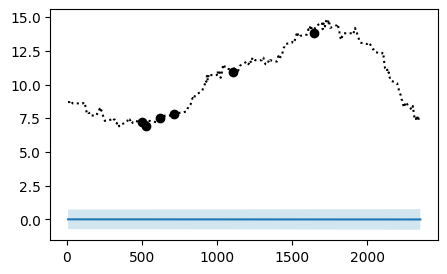

  1%|          | 1007/100001 [00:19<33:10, 49.72it/s]

iter 1001: Avg. Loss = 4.0614981832504276


  2%|▏         | 2006/100001 [00:38<31:58, 51.09it/s]

iter 2001: Avg. Loss = 2.900874336242676


  3%|▎         | 3010/100001 [00:57<31:35, 51.16it/s]

iter 3001: Avg. Loss = 2.692138548374176


  4%|▍         | 4009/100001 [01:16<31:13, 51.23it/s]

iter 4001: Avg. Loss = 2.564022864460945


  5%|▌         | 5011/100001 [01:36<30:58, 51.10it/s]

iter 5001: Avg. Loss = 2.3823261470794677


  6%|▌         | 6006/100001 [01:56<31:19, 50.00it/s]

iter 6001: Avg. Loss = 2.309934273004532


  7%|▋         | 7012/100001 [02:15<25:58, 59.67it/s]

iter 7001: Avg. Loss = 2.2863540897369385


  8%|▊         | 8011/100001 [02:33<30:46, 49.81it/s]

iter 8001: Avg. Loss = 2.2361100581884386


  9%|▉         | 9006/100001 [02:53<29:54, 50.72it/s]

iter 9001: Avg. Loss = 2.4083006291389464


 10%|█         | 10011/100001 [03:13<29:24, 50.99it/s]

iter 10001: Avg. Loss = 2.4258320547342302
iter 10001: Avg. Loss SLOW = 26.267391184210776


 11%|█         | 11007/100001 [03:32<28:47, 51.52it/s]

iter 11001: Avg. Loss = 2.4137871360778806


 12%|█▏        | 12010/100001 [03:52<28:15, 51.88it/s]

iter 12001: Avg. Loss = 2.381388795852661


 13%|█▎        | 13010/100001 [04:11<28:42, 50.49it/s]

iter 13001: Avg. Loss = 2.246792543888092


 14%|█▍        | 14010/100001 [04:31<27:53, 51.40it/s]

iter 14001: Avg. Loss = 2.196912240386009


 15%|█▌        | 15010/100001 [04:50<27:27, 51.59it/s]

iter 15001: Avg. Loss = 2.1858140251636504


 16%|█▌        | 16008/100001 [05:10<28:03, 49.88it/s]

iter 16001: Avg. Loss = 2.1743259484767914


 17%|█▋        | 17008/100001 [05:30<26:50, 51.55it/s]

iter 17001: Avg. Loss = 2.163098149061203


 18%|█▊        | 18006/100001 [05:50<27:05, 50.45it/s]

iter 18001: Avg. Loss = 2.168284487247467


 19%|█▉        | 19008/100001 [06:10<28:23, 47.56it/s]

iter 19001: Avg. Loss = 2.164370311379433


 20%|█▉        | 19999/100001 [06:29<25:55, 51.44it/s]

iter 20001: Avg. Loss = 2.2879251497983932
iter 20001: Avg. Loss SLOW = 22.38269878733158


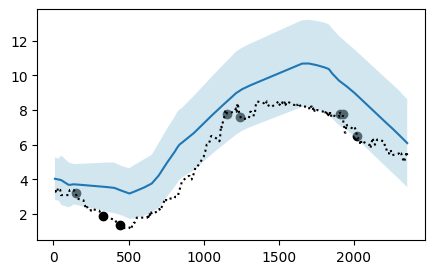

 21%|██        | 21007/100001 [06:49<25:50, 50.94it/s]

iter 21001: Avg. Loss = 2.044596143245697


 22%|██▏       | 22006/100001 [07:08<25:15, 51.45it/s]

iter 22001: Avg. Loss = 2.010113582968712


 23%|██▎       | 23007/100001 [07:26<19:52, 64.59it/s]

iter 23001: Avg. Loss = 2.0053092058897017


 24%|██▍       | 24009/100001 [07:44<24:42, 51.25it/s]

iter 24001: Avg. Loss = 1.9912057136297225


 25%|██▌       | 25011/100001 [08:04<24:06, 51.86it/s]

iter 25001: Avg. Loss = 1.9921949591636658


 26%|██▌       | 26007/100001 [08:23<24:30, 50.34it/s]

iter 26001: Avg. Loss = 1.9553825681209565


 27%|██▋       | 27006/100001 [08:43<24:13, 50.20it/s]

iter 27001: Avg. Loss = 2.026453031539917


 28%|██▊       | 28009/100001 [09:03<23:53, 50.21it/s]

iter 28001: Avg. Loss = 1.9888612965345382


 29%|██▉       | 29007/100001 [09:22<23:14, 50.91it/s]

iter 29001: Avg. Loss = 1.9431010061502456


 30%|███       | 30010/100001 [09:41<22:13, 52.49it/s]

iter 30001: Avg. Loss = 1.87399800491333
iter 30001: Avg. Loss SLOW = 19.831215512156486


 31%|███       | 31011/100001 [09:59<23:09, 49.64it/s]

iter 31001: Avg. Loss = 1.8596389956474304


 32%|███▏      | 32005/100001 [10:17<22:24, 50.59it/s]

iter 32001: Avg. Loss = 1.8390942128896712


 33%|███▎      | 33007/100001 [10:35<19:16, 57.95it/s]

iter 33001: Avg. Loss = 1.8229466189146042


 34%|███▍      | 34011/100001 [10:55<21:40, 50.74it/s]

iter 34001: Avg. Loss = 1.8271371890306474


 35%|███▌      | 35007/100001 [11:14<25:19, 42.76it/s]

iter 35001: Avg. Loss = 1.8092601054906845


 36%|███▌      | 36008/100001 [11:35<21:18, 50.05it/s]

iter 36001: Avg. Loss = 1.7962036402225494


 37%|███▋      | 37009/100001 [11:54<20:45, 50.59it/s]

iter 37001: Avg. Loss = 1.7856464788913726


 38%|███▊      | 38008/100001 [12:13<17:38, 58.55it/s]

iter 38001: Avg. Loss = 1.7994697277545928


 39%|███▉      | 39006/100001 [12:31<17:14, 58.96it/s]

iter 39001: Avg. Loss = 1.7901058073043823


 40%|███▉      | 39996/100001 [12:50<18:55, 52.83it/s]

iter 40001: Avg. Loss = 1.7617046376466752
iter 40001: Avg. Loss SLOW = 18.09120741379261


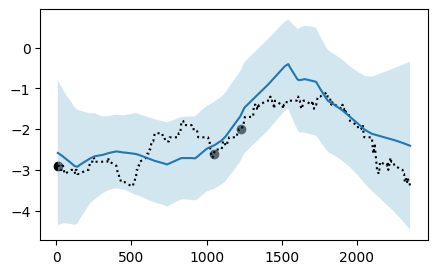

 41%|████      | 41006/100001 [13:10<19:56, 49.32it/s]

iter 41001: Avg. Loss = 1.7871663545370102


 42%|████▏     | 42010/100001 [13:29<18:56, 51.03it/s]

iter 42001: Avg. Loss = 1.7794791176319122


 43%|████▎     | 43007/100001 [13:48<18:54, 50.22it/s]

iter 43001: Avg. Loss = 1.7660069390535356


 44%|████▍     | 44010/100001 [14:07<18:20, 50.89it/s]

iter 44001: Avg. Loss = 1.7543946294784545


 45%|████▌     | 45008/100001 [14:27<18:08, 50.51it/s]

iter 45001: Avg. Loss = 1.740070233464241


 46%|████▌     | 46011/100001 [14:47<17:52, 50.36it/s]

iter 46001: Avg. Loss = 1.7627793282270432


 47%|████▋     | 47006/100001 [15:06<17:19, 51.00it/s]

iter 47001: Avg. Loss = 1.7447949829101563


 48%|████▊     | 48006/100001 [15:26<17:08, 50.57it/s]

iter 48001: Avg. Loss = 1.7651240926980973


 49%|████▉     | 49010/100001 [15:46<16:31, 51.42it/s]

iter 49001: Avg. Loss = 1.7498693029880523


 50%|█████     | 50007/100001 [16:05<15:37, 53.30it/s]

iter 50001: Avg. Loss = 1.7507645725011824
iter 50001: Avg. Loss SLOW = 17.600449553489685


 51%|█████     | 51006/100001 [16:25<17:02, 47.89it/s]

iter 51001: Avg. Loss = 1.7447815593481064


 52%|█████▏    | 52006/100001 [16:45<15:41, 50.98it/s]

iter 52001: Avg. Loss = 1.7214999796152115


 53%|█████▎    | 53009/100001 [17:05<15:15, 51.32it/s]

iter 53001: Avg. Loss = 1.7374038982391358


 54%|█████▍    | 54008/100001 [17:25<14:56, 51.32it/s]

iter 54001: Avg. Loss = 1.7370776970386506


 55%|█████▌    | 55010/100001 [17:44<14:36, 51.35it/s]

iter 55001: Avg. Loss = 1.713075044631958


 56%|█████▌    | 56008/100001 [18:03<14:02, 52.22it/s]

iter 56001: Avg. Loss = 1.7193781390190124


 57%|█████▋    | 57011/100001 [18:23<14:03, 50.98it/s]

iter 57001: Avg. Loss = 1.7130498499870301


 58%|█████▊    | 58010/100001 [18:43<14:01, 49.91it/s]

iter 58001: Avg. Loss = 1.6954391609430313


 59%|█████▉    | 59007/100001 [19:03<13:24, 50.97it/s]

iter 59001: Avg. Loss = 1.713956338763237


 60%|█████▉    | 60000/100001 [19:23<13:36, 48.99it/s]

iter 60001: Avg. Loss = 1.7176819347143173
iter 60001: Avg. Loss SLOW = 17.21334360229969


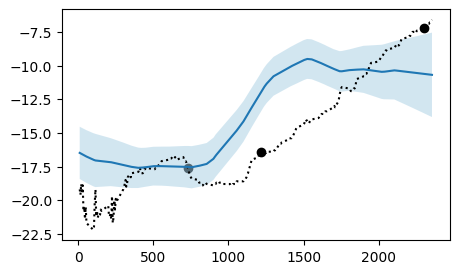

 61%|██████    | 61008/100001 [19:43<12:46, 50.88it/s]

iter 61001: Avg. Loss = 1.6931814498901367


 62%|██████▏   | 62006/100001 [20:03<12:31, 50.57it/s]

iter 62001: Avg. Loss = 1.7101256093978883


 63%|██████▎   | 63009/100001 [20:23<12:18, 50.11it/s]

iter 63001: Avg. Loss = 1.6992936928272246


 64%|██████▍   | 64010/100001 [20:43<12:00, 49.96it/s]

iter 64001: Avg. Loss = 1.6781137804985047


 65%|██████▌   | 65009/100001 [21:02<11:31, 50.57it/s]

iter 65001: Avg. Loss = 1.6886885608434676


 66%|██████▌   | 66007/100001 [21:23<11:19, 50.00it/s]

iter 66001: Avg. Loss = 1.6972213912010192


 67%|██████▋   | 67010/100001 [21:43<10:57, 50.21it/s]

iter 67001: Avg. Loss = 1.683317830324173


 68%|██████▊   | 68008/100001 [22:02<10:30, 50.73it/s]

iter 68001: Avg. Loss = 1.6906862803697587


 69%|██████▉   | 69011/100001 [22:22<10:16, 50.27it/s]

iter 69001: Avg. Loss = 1.6978107825517654


 70%|███████   | 70007/100001 [22:42<10:03, 49.73it/s]

iter 70001: Avg. Loss = 1.6754534668922425
iter 70001: Avg. Loss SLOW = 16.91389284479618


 71%|███████   | 71008/100001 [23:02<09:43, 49.71it/s]

iter 71001: Avg. Loss = 1.6631023404598235


 72%|███████▏  | 72012/100001 [23:21<07:35, 61.48it/s]

iter 72001: Avg. Loss = 1.660915193796158


 73%|███████▎  | 73009/100001 [23:40<08:29, 53.00it/s]

iter 73001: Avg. Loss = 1.675356810927391


 74%|███████▍  | 74010/100001 [23:59<06:53, 62.81it/s]

iter 74001: Avg. Loss = 1.6682526164054872


 75%|███████▌  | 75008/100001 [24:16<07:43, 53.88it/s]

iter 75001: Avg. Loss = 1.6589140235185622


 76%|███████▌  | 76006/100001 [24:34<08:22, 47.78it/s]

iter 76001: Avg. Loss = 1.6426427270174027


 77%|███████▋  | 77008/100001 [24:53<07:12, 53.11it/s]

iter 77001: Avg. Loss = 1.633036452293396


 78%|███████▊  | 78010/100001 [25:11<07:06, 51.51it/s]

iter 78001: Avg. Loss = 1.6469751529693604


 79%|███████▉  | 79010/100001 [25:30<06:19, 55.31it/s]

iter 79001: Avg. Loss = 1.643297882437706


 80%|███████▉  | 79998/100001 [25:48<06:03, 54.96it/s]

iter 80001: Avg. Loss = 1.6446757433414458
iter 80001: Avg. Loss SLOW = 16.537168943166733


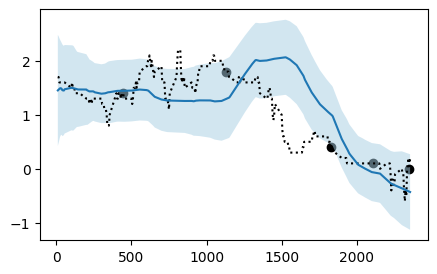

 81%|████████  | 81011/100001 [26:07<06:03, 52.23it/s]

iter 81001: Avg. Loss = 1.6681937012672425


 82%|████████▏ | 82010/100001 [26:25<05:44, 52.26it/s]

iter 82001: Avg. Loss = 1.6252949184179306


 83%|████████▎ | 83011/100001 [26:44<05:21, 52.86it/s]

iter 83001: Avg. Loss = 1.6286321276426314


 84%|████████▍ | 84008/100001 [27:02<05:04, 52.50it/s]

iter 84001: Avg. Loss = 1.6154508038759232


 85%|████████▌ | 85013/100001 [27:20<04:17, 58.14it/s]

iter 85001: Avg. Loss = 1.6376488490104675


 86%|████████▌ | 86009/100001 [27:38<04:28, 52.09it/s]

iter 86001: Avg. Loss = 1.5975524713993072


 87%|████████▋ | 87006/100001 [27:55<04:10, 51.95it/s]

iter 87001: Avg. Loss = 1.6346402037143708


 88%|████████▊ | 88009/100001 [28:13<03:10, 62.87it/s]

iter 88001: Avg. Loss = 1.594926044344902


 89%|████████▉ | 89008/100001 [28:30<03:19, 55.09it/s]

iter 89001: Avg. Loss = 1.6236581666469574


 90%|█████████ | 90012/100001 [28:48<02:34, 64.77it/s]

iter 90001: Avg. Loss = 1.6077337245941161
iter 90001: Avg. Loss SLOW = 16.23373101091385


 91%|█████████ | 91009/100001 [29:03<02:13, 67.30it/s]

iter 91001: Avg. Loss = 1.6140988348722458


 92%|█████████▏| 92008/100001 [29:19<02:10, 61.47it/s]

iter 92001: Avg. Loss = 1.6141732846498489


 93%|█████████▎| 93008/100001 [29:35<01:53, 61.52it/s]

iter 93001: Avg. Loss = 1.620817617535591


 94%|█████████▍| 94008/100001 [29:52<01:44, 57.48it/s]

iter 94001: Avg. Loss = 1.5918829696178436


 95%|█████████▌| 95009/100001 [30:10<01:18, 63.31it/s]

iter 95001: Avg. Loss = 1.601419890165329


 96%|█████████▌| 96012/100001 [30:27<01:09, 57.47it/s]

iter 96001: Avg. Loss = 1.5984664154052735


 97%|█████████▋| 97011/100001 [30:43<00:49, 60.19it/s]

iter 97001: Avg. Loss = 1.5928586721420288


 98%|█████████▊| 98013/100001 [31:00<00:32, 60.70it/s]

iter 98001: Avg. Loss = 1.5716045820713043


 99%|█████████▉| 99012/100001 [31:17<00:16, 59.41it/s]

iter 99001: Avg. Loss = 1.5906073424816132


100%|█████████▉| 99996/100001 [31:33<00:00, 56.65it/s]

iter 100001: Avg. Loss = 1.6099352111816407
iter 100001: Avg. Loss SLOW = 16.005864820122717


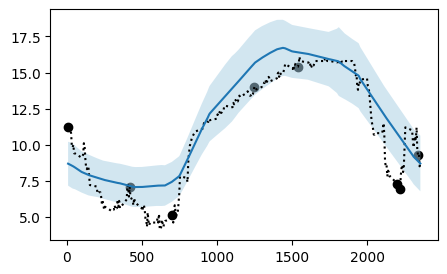

100%|██████████| 100001/100001 [31:33<00:00, 52.80it/s]


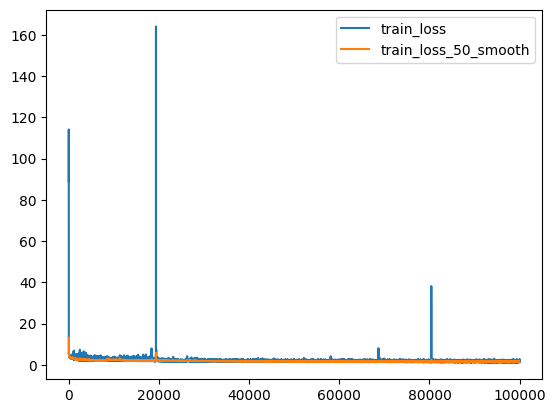

In [22]:
from src.plot import plot_predictive
from src.np import NeuralProcess
from tqdm import tqdm

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=4,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=5,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=True,
                   use_latent_self_attn=True,
                   use_determ_self_attn=False,
                   use_determ_cross_attn=True
                   )
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data_path = '../data/data.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in tqdm(range(100000+1)):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=64, device=device)
    p_y_pred, loss, log_lik = np(batch.x_context, batch.y_context, batch.x_target, None, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

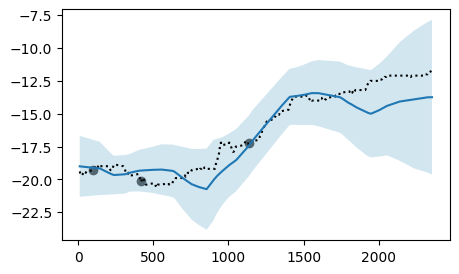

In [67]:
np.training = False
batch = data.generate_batch(batch_size=1, device=np.device)
plot_predictive(np, batch, knowledge=None, save=False, iter=None)
np.training = True


In [69]:
import transformers
from transformers import RobertaModel, RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
langmodel = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
langmodel.to(device)
# freeze everything
for name, param in langmodel.named_parameters():
    #  if name == "pooler.dense.weight" or name == "pooler.dense.bias":
    #     param.requires_grad = True
    #  else:
    param.requires_grad = False

#verify
for name, param in langmodel.named_parameters():
    print(name,param.requires_grad)

/home/w/IML/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.token_type_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias False
encoder.layer.1.attention.self.query

NeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): ReLU()
        (10): Linear(in_features=128, out_features=128, bias=True)
        (11): Identity()
      )
    )
    (rho): Linear(in_features=128, out_features=128, bias=True)
    (cross_attention_block): CrossAttention(
      (q_proj): Linear(in_features=128, out_features=128, bias=True)
      (k_proj): Linear(in_features=128, out_features=128, bias=True)
      (v_proj): Linear(in_features=128, out_features=128, bias=True)
      (o_proj): Linear(in_features=128, 

  0%|          | 0/100001 [00:00<?, ?it/s]

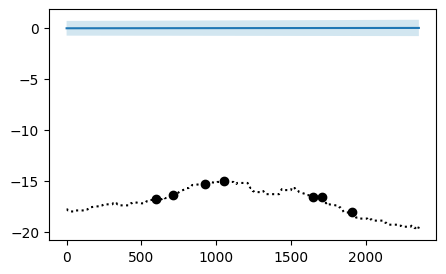

  1%|          | 1006/100001 [00:33<55:58, 29.48it/s]

iter 1001: Avg. Loss = 4.55817398929596


  2%|▏         | 2006/100001 [01:07<51:18, 31.83it/s]

iter 2001: Avg. Loss = 3.7723251523971557


  3%|▎         | 3006/100001 [01:40<54:52, 29.46it/s]

iter 3001: Avg. Loss = 145.2608692882061


  4%|▍         | 4004/100001 [02:13<53:21, 29.99it/s]

iter 4001: Avg. Loss = 2.8372761907577515


  5%|▌         | 5004/100001 [02:46<53:25, 29.63it/s]

iter 5001: Avg. Loss = 2.594788699746132


  6%|▌         | 6004/100001 [03:20<52:06, 30.06it/s]

iter 6001: Avg. Loss = 2.5801179920434953


  7%|▋         | 7006/100001 [03:53<50:46, 30.53it/s]

iter 7001: Avg. Loss = 2.4671902124881746


  8%|▊         | 8006/100001 [04:26<51:13, 29.93it/s]

iter 8001: Avg. Loss = 2.452869224667549


  9%|▉         | 9006/100001 [05:00<46:14, 32.79it/s]

iter 9001: Avg. Loss = 2.38536993265152


 10%|█         | 10004/100001 [05:32<50:45, 29.55it/s]

iter 10001: Avg. Loss = 2.3160227031707765
iter 10001: Avg. Loss SLOW = 171.2250033854246


 11%|█         | 11007/100001 [06:06<49:27, 29.99it/s]

iter 11001: Avg. Loss = 2.2119099467992784


 12%|█▏        | 12005/100001 [06:39<48:29, 30.25it/s]

iter 12001: Avg. Loss = 2.5846196551322937


 13%|█▎        | 13006/100001 [07:13<48:23, 29.97it/s]

iter 13001: Avg. Loss = 2.5742769038677213


 14%|█▍        | 14007/100001 [07:45<47:32, 30.15it/s]

iter 14001: Avg. Loss = 2.457335577726364


 15%|█▌        | 15005/100001 [08:18<46:53, 30.21it/s]

iter 15001: Avg. Loss = 2.4161523917913437


 16%|█▌        | 16005/100001 [08:51<46:53, 29.85it/s]

iter 16001: Avg. Loss = 2.3860993019342422


 17%|█▋        | 17003/100001 [09:25<45:43, 30.25it/s]

iter 17001: Avg. Loss = 2.345497728943825


 18%|█▊        | 18006/100001 [09:58<44:40, 30.59it/s]

iter 18001: Avg. Loss = 2.34254301905632


 19%|█▉        | 19003/100001 [10:31<44:25, 30.39it/s]

iter 19001: Avg. Loss = 2.309598006248474


 20%|█▉        | 19998/100001 [11:05<43:59, 30.31it/s]

iter 20001: Avg. Loss = 2.3202957125902177
iter 20001: Avg. Loss SLOW = 23.94832824409008


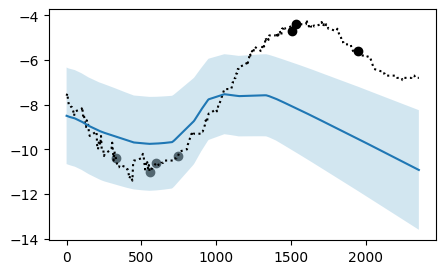

 21%|██        | 21005/100001 [11:38<43:13, 30.46it/s]

iter 21001: Avg. Loss = 2.3140419701337813


 22%|██▏       | 22006/100001 [12:12<42:48, 30.36it/s]

iter 22001: Avg. Loss = 2.3079225410223008


 23%|██▎       | 23004/100001 [12:45<42:39, 30.09it/s]

iter 23001: Avg. Loss = 2.3008670278787613


 24%|██▍       | 24006/100001 [13:18<41:58, 30.17it/s]

iter 24001: Avg. Loss = 2.304414862990379


 25%|██▌       | 25005/100001 [13:51<41:51, 29.86it/s]

iter 25001: Avg. Loss = 2.2681318821907044


 26%|██▌       | 26005/100001 [14:25<41:57, 29.39it/s]

iter 26001: Avg. Loss = 2.2689629683494568


 27%|██▋       | 27005/100001 [14:58<39:43, 30.63it/s]

iter 27001: Avg. Loss = 2.229993002772331


 28%|██▊       | 28006/100001 [15:31<40:04, 29.95it/s]

iter 28001: Avg. Loss = 2.244548672199249


 29%|██▉       | 29007/100001 [16:04<39:16, 30.13it/s]

iter 29001: Avg. Loss = 2.2454510141611097


 30%|███       | 30005/100001 [16:37<38:47, 30.07it/s]

iter 30001: Avg. Loss = 2.2420387389659884
iter 30001: Avg. Loss SLOW = 22.726372680664063


 31%|███       | 31004/100001 [17:11<38:39, 29.74it/s]

iter 31001: Avg. Loss = 2.2355771704912186


 32%|███▏      | 32006/100001 [17:44<36:47, 30.80it/s]

iter 32001: Avg. Loss = 2.2482160588502884


 33%|███▎      | 33004/100001 [18:17<37:33, 29.74it/s]

iter 33001: Avg. Loss = 2.2142466645240786


 34%|███▍      | 34004/100001 [18:50<33:31, 32.81it/s]

iter 34001: Avg. Loss = 2.200779264807701


 35%|███▌      | 35005/100001 [19:23<35:51, 30.21it/s]

iter 35001: Avg. Loss = 2.218281470298767


 36%|███▌      | 36006/100001 [19:56<36:03, 29.58it/s]

iter 36001: Avg. Loss = 2.2142563108205797


 37%|███▋      | 37005/100001 [20:30<35:10, 29.84it/s]

iter 37001: Avg. Loss = 2.1877100151777267


 38%|███▊      | 38006/100001 [21:03<34:50, 29.66it/s]

iter 38001: Avg. Loss = 2.1975030746459963


 39%|███▉      | 39007/100001 [21:36<33:34, 30.27it/s]

iter 39001: Avg. Loss = 2.181777549147606


 40%|███▉      | 39997/100001 [22:09<33:02, 30.27it/s]

iter 40001: Avg. Loss = 2.266423235416412
iter 40001: Avg. Loss SLOW = 22.164770814180375


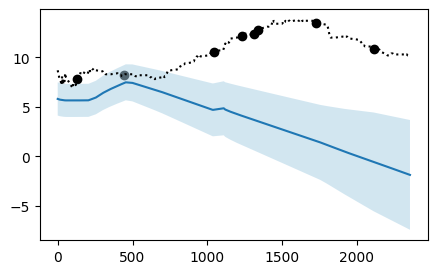

 41%|████      | 41005/100001 [22:43<33:30, 29.35it/s]

iter 41001: Avg. Loss = 2.2027088251113893


 42%|████▏     | 42007/100001 [23:16<31:43, 30.46it/s]

iter 42001: Avg. Loss = 2.1913783363103865


 43%|████▎     | 43006/100001 [23:49<31:57, 29.72it/s]

iter 43001: Avg. Loss = 2.1675628464221957


 44%|████▍     | 44004/100001 [24:22<30:55, 30.19it/s]

iter 44001: Avg. Loss = 2.1687926273345948


 45%|████▌     | 45005/100001 [24:56<30:55, 29.64it/s]

iter 45001: Avg. Loss = 2.1882294257879256


 46%|████▌     | 46005/100001 [25:29<29:56, 30.06it/s]

iter 46001: Avg. Loss = 2.168981800317764


 47%|████▋     | 47006/100001 [26:03<29:45, 29.67it/s]

iter 47001: Avg. Loss = 2.157712452530861


 48%|████▊     | 48006/100001 [26:36<28:38, 30.25it/s]

iter 48001: Avg. Loss = 2.163512468934059


 49%|████▉     | 49004/100001 [27:10<28:52, 29.43it/s]

iter 49001: Avg. Loss = 2.227021562933922


 50%|█████     | 50006/100001 [27:42<27:34, 30.21it/s]

iter 50001: Avg. Loss = 2.17884161567688
iter 50001: Avg. Loss SLOW = 21.814741961359978


 51%|█████     | 51005/100001 [28:15<26:51, 30.41it/s]

iter 51001: Avg. Loss = 2.1291081566810606


 52%|█████▏    | 52005/100001 [28:49<26:32, 30.13it/s]

iter 52001: Avg. Loss = 2.1474633249044417


 53%|█████▎    | 53005/100001 [29:22<26:04, 30.04it/s]

iter 53001: Avg. Loss = 2.123096127510071


 54%|█████▍    | 54007/100001 [29:55<25:41, 29.83it/s]

iter 54001: Avg. Loss = 2.116504266023636


 55%|█████▌    | 55006/100001 [30:28<25:15, 29.70it/s]

iter 55001: Avg. Loss = 2.0990169196128847


 56%|█████▌    | 56007/100001 [31:02<23:59, 30.56it/s]

iter 56001: Avg. Loss = 2.173685813188553


 57%|█████▋    | 57004/100001 [31:35<23:53, 30.00it/s]

iter 57001: Avg. Loss = 2.0907015792131425


 58%|█████▊    | 58003/100001 [32:08<23:34, 29.69it/s]

iter 58001: Avg. Loss = 2.069550216436386


 59%|█████▉    | 59004/100001 [32:41<22:54, 29.83it/s]

iter 59001: Avg. Loss = 2.087343559741974


 60%|█████▉    | 59997/100001 [33:14<21:52, 30.47it/s]

iter 60001: Avg. Loss = 2.069223347425461
iter 60001: Avg. Loss SLOW = 21.10569331073761


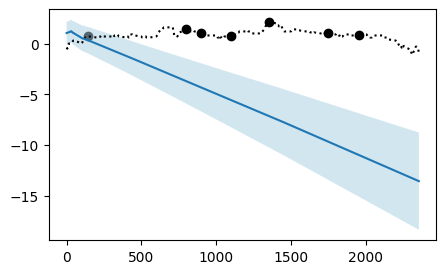

 61%|██████    | 61005/100001 [33:48<21:26, 30.32it/s]

iter 61001: Avg. Loss = 2.0432895152568817


 62%|██████▏   | 62004/100001 [34:21<20:52, 30.34it/s]

iter 62001: Avg. Loss = 2.0484290707111357


 63%|██████▎   | 63006/100001 [34:55<20:50, 29.59it/s]

iter 63001: Avg. Loss = 2.0635939638614653


 64%|██████▍   | 64005/100001 [35:28<20:11, 29.72it/s]

iter 64001: Avg. Loss = 2.028796895623207


 65%|██████▌   | 65005/100001 [36:01<19:16, 30.27it/s]

iter 65001: Avg. Loss = 2.0475475105047227


 66%|██████▌   | 66005/100001 [36:35<18:50, 30.06it/s]

iter 66001: Avg. Loss = 2.008208194732666


 67%|██████▋   | 67005/100001 [37:07<18:23, 29.90it/s]

iter 67001: Avg. Loss = 2.000505626678467


 68%|██████▊   | 68004/100001 [37:41<18:05, 29.46it/s]

iter 68001: Avg. Loss = 2.0280932554006577


 69%|██████▉   | 69004/100001 [38:14<16:59, 30.42it/s]

iter 69001: Avg. Loss = 1.9836348321437836


 70%|███████   | 70005/100001 [38:48<16:33, 30.19it/s]

iter 70001: Avg. Loss = 1.964025405049324
iter 70001: Avg. Loss SLOW = 20.21612426996231


 71%|███████   | 71003/100001 [39:21<16:37, 29.06it/s]

iter 71001: Avg. Loss = 1.9588706648349763


 72%|███████▏  | 72006/100001 [39:55<15:42, 29.71it/s]

iter 72001: Avg. Loss = 1.9885933672189713


 73%|███████▎  | 73004/100001 [40:28<15:14, 29.54it/s]

iter 73001: Avg. Loss = 1.9765777742862702


 74%|███████▍  | 74004/100001 [41:01<14:41, 29.49it/s]

iter 74001: Avg. Loss = 1.95739393556118


 75%|███████▌  | 75006/100001 [41:35<14:00, 29.74it/s]

iter 75001: Avg. Loss = 1.9808291128873825


 76%|███████▌  | 76005/100001 [42:07<12:14, 32.67it/s]

iter 76001: Avg. Loss = 1.9624924544095994


 77%|███████▋  | 77006/100001 [42:41<12:53, 29.73it/s]

iter 77001: Avg. Loss = 1.9427224963903427


 78%|███████▊  | 78005/100001 [43:14<12:18, 29.80it/s]

iter 78001: Avg. Loss = 1.964983027935028


 79%|███████▉  | 79006/100001 [43:47<11:31, 30.38it/s]

iter 79001: Avg. Loss = 1.9500253200531006


 80%|███████▉  | 79999/100001 [44:21<11:30, 28.95it/s]

iter 80001: Avg. Loss = 1.9272869569063187
iter 80001: Avg. Loss SLOW = 19.60977511048317


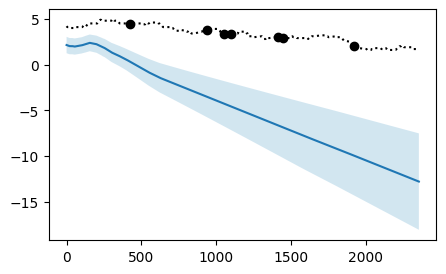

 81%|████████  | 81004/100001 [44:54<10:37, 29.80it/s]

iter 81001: Avg. Loss = 1.9247532082796097


 82%|████████▏ | 82004/100001 [45:28<10:39, 28.16it/s]

iter 82001: Avg. Loss = 1.9547644721269608


 83%|████████▎ | 83006/100001 [46:01<09:24, 30.11it/s]

iter 83001: Avg. Loss = 1.926888473510742


 84%|████████▍ | 84005/100001 [46:34<08:54, 29.93it/s]

iter 84001: Avg. Loss = 1.9017351158857345


 85%|████████▌ | 85005/100001 [47:08<08:21, 29.88it/s]

iter 85001: Avg. Loss = 1.9059141087532043


 86%|████████▌ | 86004/100001 [47:41<07:45, 30.09it/s]

iter 86001: Avg. Loss = 1.9257034811973572


 87%|████████▋ | 87006/100001 [48:15<07:19, 29.59it/s]

iter 87001: Avg. Loss = 1.910168628334999


 88%|████████▊ | 88006/100001 [48:48<06:48, 29.33it/s]

iter 88001: Avg. Loss = 1.9143948304653167


 89%|████████▉ | 89006/100001 [49:21<06:08, 29.87it/s]

iter 89001: Avg. Loss = 1.8849174441099168


 90%|█████████ | 90004/100001 [49:54<05:34, 29.89it/s]

iter 90001: Avg. Loss = 1.9350274233818054
iter 90001: Avg. Loss SLOW = 19.18426718604565


 91%|█████████ | 91006/100001 [50:27<05:01, 29.83it/s]

iter 91001: Avg. Loss = 1.8860006059408188


 92%|█████████▏| 92004/100001 [51:00<04:34, 29.18it/s]

iter 92001: Avg. Loss = 1.901904255270958


 93%|█████████▎| 93005/100001 [51:33<03:51, 30.18it/s]

iter 93001: Avg. Loss = 1.9214549828767777


 94%|█████████▍| 94004/100001 [52:06<03:20, 29.92it/s]

iter 94001: Avg. Loss = 1.9138055053949357


 95%|█████████▌| 95007/100001 [52:40<02:43, 30.61it/s]

iter 95001: Avg. Loss = 1.9114678596258163


 96%|█████████▌| 96006/100001 [53:13<02:12, 30.08it/s]

iter 96001: Avg. Loss = 1.8672225483655929


 97%|█████████▋| 97007/100001 [53:46<01:40, 29.85it/s]

iter 97001: Avg. Loss = 1.8783512105941773


 98%|█████████▊| 98006/100001 [54:19<01:06, 30.17it/s]

iter 98001: Avg. Loss = 1.9012629942893982


 99%|█████████▉| 99005/100001 [54:52<00:32, 30.56it/s]

iter 99001: Avg. Loss = 1.9049056693315507


100%|█████████▉| 99999/100001 [55:25<00:00, 29.84it/s]

iter 100001: Avg. Loss = 1.8842548823356629
iter 100001: Avg. Loss SLOW = 18.97063051402569


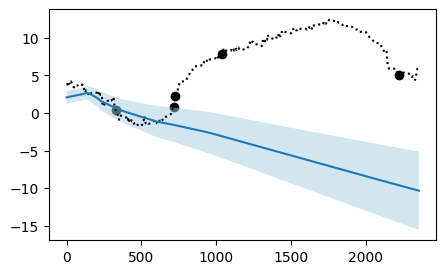

100%|██████████| 100001/100001 [55:25<00:00, 30.07it/s]


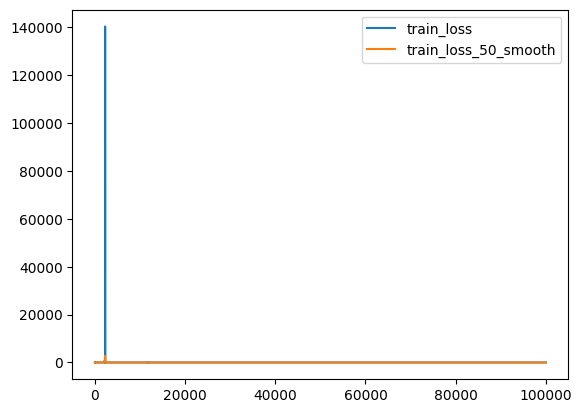

In [81]:
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

# np = NeuralProcess(x_dim=x_dim,
#                    y_dim=y_dim,
#                    hidden_dim=hidden_dim,
#                    latent_dim=latent_dim,
#                    determ_dim=determ_dim,
#                    knowledge_dim=768,
#                    n_h_layers_decoder=3,
#                    n_h_layers_phi_latent_encoder=2,
#                    n_h_layers_rho_latent_encoder=1,
#                    n_h_layers_phi_determ_encoder=6,
#                    n_h_layers_rho_determ_encoder=0,
#                    use_deterministic_path=False,
#                    )

np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=4,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=5,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=True,
                   use_latent_self_attn=True,
                   use_determ_self_attn=False,
                   use_determ_cross_attn=True,
                   use_knowledge=True,
                   use_linear_knowledge_encoder=True,
                   knowledge_dim=768
                   )
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in tqdm(range(100000+1)):
    np.training = True
    optimiser.zero_grad()

    batch, knowledge = data.generate_batch(batch_size=6, device=device, return_knowledge=True)
    # print(knowledge)
    tokens = tokenizer.batch_encode_plus(
            list(knowledge),
            add_special_tokens=True,
            max_length=100,
            padding='max_length',
            return_token_type_ids=True
        )
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)
    token_type_ids = torch.tensor(tokens['token_type_ids']).to(device)
    lang_output = langmodel(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    knowledge = lang_output.pooler_output.unsqueeze(1)
    # print(knowledge.shape)

    p_y_pred, loss, log_lik = np(batch.x_context, batch.y_context, batch.x_target, knowledge, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()

    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
